# Lab CMBLenses

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl/examples`


In [2]:
using Revise, Adapt, CMBLensing, CMBLensingInferenceTestProblem, CUDA, JLD2, LaTeXStrings, LinearAlgebra, 
    MCMCChains, MCMCDiagnosticTools, MicroCanonicalHMC, MuseInference, MuseInference, Plots, 
    ProgressMeter, Random, Statistics, Zygote

In [3]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [4]:
Nside = 64
T = Float64;

In [6]:
prob = load_cmb_lensing_problem(;storage=CuArray, T, Nside, masking=true, global_parameters=true);

# MCHMC

In [7]:
target = CMBLensingTarget(prob);

In [8]:
d = length(prob.Ωstart)
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart);

In [9]:
p_precond = load("../chains/pixel_preconditioners/pp_nside_64", 
               "dist_mat_precond")
p_precond = adapt(CuArray, p_precond)
p_precond = from_vec(p_precond);

In [10]:
precond = one(simulate(Diagonal(one(LenseBasis(diag(prob.Λmass))))));

## Sample

In [11]:
TEV = 0.0001
spl = MCHMC(500, TEV; adaptive=true, init_eps=30, init_L=10.0*sqrt(50), sigma=precond);

In [12]:
prob.ncalls[] = 0
samples_mchmc = adapt(Array, Sample(spl, target, 10_000, dialog=false, progress=true,
                      file_name=string("../chains/MCHMC/CMBLensing__masked_TEV_", TEV)));
ncalls_mchmc = prob.ncalls[]

MCHMC:  26%|███████████▌                                |  ETA: 0:10:58
  ϵ:     11.521798516152575
  dE/d:  1.841166270152265e-5

LoadError: InterruptException:

In [ ]:
esss, _ = MicroCanonicalHMC.Summarize(samples_mchmc)
ess_per_call_mchmc = mean(esss) / ncalls_mchmc

## Plot

In [ ]:
std(chain_mchmc[:dE])^2/d

In [ ]:
plot(chain_mchmc[:dE]/d, label=L"\mathrm{Energy}/d", xlabel="step")

In [ ]:
vars = var(samples_mchmc, dims=2)[1:d]
_vars = var(samples_mchmc, dims=2)[d+1:2*d]

In [ ]:
k = round(maximum(vars)/minimum(vars), digits=2)
_k = round(maximum(_vars)/minimum(_vars), digits=2)

In [ ]:
plot(_vars, title="Diag(cov) - Masked", label=string("Latent space --> K = ", _k))
plot!(vars, label=string("Parameter space --> K = ", k))

In [ ]:
using CMBLensing: fit, Histogram, Weights
_vars_q = _vars[1:Int((d-2)/3)]
_vars_u = _vars[Int((d-2)/3)+1:Int(2*(d-2)/3)];

In [ ]:
_edges = range(0,13,length=20)
hist_vars_q = fit(Histogram, vec(dist_mat), Weights(_vars_q), _edges).weights ./ fit(Histogram, vec(dist_mat), Weights(ones(length(_vars_q))), _edges).weights
hist_vars_u = fit(Histogram, vec(dist_mat), Weights(_vars_u), _edges).weights ./ fit(Histogram, vec(dist_mat), Weights(ones(length(_vars_q))), _edges).weights
plot(_edges, hist_vars_q, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="Q-field", alpha=0.7)
plot!(_edges, hist_vars_u, seriestype=:scatter,
     xlabel="distance to edge",
     ylabel="variance of pixel",
     label="U-field", alpha=0.7)

### Animation

In [26]:
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart)
last_sample = from_vec(samples_mchmc[end][1:end-2]);

LoadError: MethodError: no method matching getindex(::Float64, ::UnitRange{Int64})

[0mClosest candidates are:
[0m  getindex(::Union{Real, Field, FieldOp}, [91m::typeof(!)[39m, [91m::Any[39m)
[0m[90m   @[39m [35mCMBLensing[39m [90m~/.julia/packages/CMBLensing/ujQ46/src/[39m[90m[4mgeneric.jl:362[24m[39m
[0m  getindex(::Number)
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:95[24m[39m
[0m  getindex(::Union{AbstractChar, Number}, [91m::CartesianIndex{0}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mmultidimensional.jl:853[24m[39m
[0m  ...


In [27]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(last_sample[k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)

LoadError: UndefVarError: `last_sample` not defined

In [28]:
ϕs = [∇²*from_vec(sample[1:end-2]).ϕ°/2 for sample in samples_mchmc[end-500:end]]
anim = @animate for i in 1:length(ϕs)
    motionblur = [0.5, 1, 0.5]
    frame = sum(circshift(ϕs, i)[1:length(motionblur)] .* motionblur) / sum(motionblur)
    plot(1 * frame, clims=(-0.5, 0.5), c=:thermal, title="κ samples")
end;

LoadError: MethodError: no method matching getindex(::Float64, ::UnitRange{Int64})

[0mClosest candidates are:
[0m  getindex(::Union{Real, Field, FieldOp}, [91m::typeof(!)[39m, [91m::Any[39m)
[0m[90m   @[39m [35mCMBLensing[39m [90m~/.julia/packages/CMBLensing/ujQ46/src/[39m[90m[4mgeneric.jl:362[24m[39m
[0m  getindex(::Number)
[0m[90m   @[39m [90mBase[39m [90m[4mnumber.jl:95[24m[39m
[0m  getindex(::Union{AbstractChar, Number}, [91m::CartesianIndex{0}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mmultidimensional.jl:853[24m[39m
[0m  ...


In [29]:
mp4(anim, "kappa_samples.mp4", fps = 25)

LoadError: UndefVarError: `anim` not defined

# HMC

In [6]:
Ω = prob.Ωstart
samples_hmc = []
rng = Xoshiro(1)
prob.ncalls[] = 0
@showprogress for i=1:500
    Ω, = state = hmc_step(rng, prob, Ω, prob.Λmass; symp_kwargs=[(N=25, ϵ=0.05)], progress=false, always_accept=(i<10))
    push!(samples_hmc, state)
end
ncalls_hmc = prob.ncalls[]

Progress: 100%|█████████████████████████████████████████| Time: 0:12:24


28000

In [7]:
_samples_hmc = zeros(500, 3*64^2)
for i in 1:500
    _samples_hmc[i, :]  = samples_hmc[i][1][:]
end
_samples_hmc

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fb24c17df50.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/HaQcr/src/GPUArraysCore.jl:106


500×12288 Matrix{Float64}:
  0.880121  -0.0171894  0.93848   …  5.75049e-6  5.52695e-6  5.27141e-6
  1.51976   -0.0603458  1.53         5.76893e-6  5.55676e-6  5.29591e-6
  0.769549   0.482261   0.945416     5.83663e-6  5.57823e-6  5.34425e-6
 -0.299192   0.797702   0.454957     5.11987e-6  4.8158e-6   4.53722e-6
  1.46688    1.7819     0.84227      5.62815e-6  5.29113e-6  4.90999e-6
  1.33471    2.23918    1.41934   …  5.51712e-6  5.19077e-6  4.82688e-6
  1.32536    2.06012    1.82736      5.94324e-6  5.63205e-6  5.27875e-6
  1.45257    1.66544    1.56779      5.30605e-6  5.01454e-6  4.73151e-6
  1.74745    2.69022    2.19151      5.5865e-6   5.26217e-6  4.94683e-6
  1.40203    2.58277    1.0309       5.33357e-6  4.89036e-6  4.42816e-6
  1.17438    0.777196   0.756487  …  5.73433e-6  5.32184e-6  4.90778e-6
  1.25865   -0.0788151  1.21972      5.4368e-6   5.00951e-6  4.64358e-6
  2.21506    0.648366   0.357549     5.49086e-6  5.09517e-6  4.70383e-6
  ⋮                               ⋱  

In [8]:
@save "../chains/HMC/CMBLensing_no_cosmo_masked_NSIDE_64" _samples_hmc

In [14]:
ess_hmc = MCMCDiagnosticTools.ess(chain_hmc)[[:r,:Aϕ],:ess]

LoadError: UndefVarError: `chain_hmc` not defined

In [30]:
ess_per_call_hmc = ess_hmc ./ ncalls_hmc

2-element Vector{Float64}:
 0.0002077366415772459
 0.00028330503372299816

# MUSE

In [7]:
using CMBLensing.ComponentArrays, MuseInference.FiniteDifferences

In [8]:
muse_prob = CMBLensingMuseProblem(
    prob.ds, 
    MAP_joint_kwargs = (minsteps=3, nsteps=15, αtol=1e-2, gradtol=3e-5, progress=false, history_keys=(:logpdf, :ΔΩ°_norm)),
);

In [9]:
# small hack to allow getting MUSE covariance in terms of transformed θ
CMBLensingMuseInferenceExt = Base.get_extension(CMBLensing,:CMBLensingMuseInferenceExt)
CMBLensingMuseInferenceExt.mergeθ(prob::CMBLensingMuseInferenceExt.CMBLensingMuseProblem, θ) = exp.(θ)

In [10]:
# z₀ = zero(FieldTuple(MuseInference.select(NamedTuple(prob.Ωstart), (:f°, :ϕ°))))
# H_pre = Diagonal(FieldTuple(MuseInference.select(NamedTuple(prob.Λmass.diag), (:f°, :ϕ°))))
# H_pre_map = let H_pre=H_pre, z₀=z₀
#     MuseInference.LinearMap{eltype(z₀)}(length(z₀), issymmetric=true) do z
#         f, = promote(z, z₀)
#         LenseBasis(H_pre \ f)[:]
#     end
# end
# implicit_diff_cg_kwargs = (maxiter=1500,Pl=MuseInference.InverseMap(H_pre_map));

In [11]:
z₀ = zero(MuseInference.sample_x_z(muse_prob, Xoshiro(0), prob.Ωstart.θ).z);
result = MuseResult()
nsims = 200
rng = Xoshiro(0)

prob.ncalls[] = 0
MuseInference.muse!(result,  muse_prob, prob.Ωstart.θ; nsims, rng, z₀, maxsteps=2, θ_rtol=0, progress=true, save_MAPs=false)
MuseInference.get_J!(result, muse_prob; nsims,   rng, z₀, progress=true)
MuseInference.get_H!(result, muse_prob; nsims=4, rng, z₀, progress=true, step=std(result.gs)/100, fdm=central_fdm(2,1,adapt=0))
ncalls_muse = prob.ncalls[];

MUSE: 100%|█████████████████████████████████████████████| Time: 0:07:52
get_H: 100%|████████████████████████████████████████████| Time: 0:00:23


In [12]:
chain_muse = Chains(permutedims(rand(result.dist,1000000)), [:logr, :logAϕ]);

In [13]:
@save "../chains/MUSE/CMBLensing_unmasked_NSIDE_64" chain_muse

In [15]:
chain_muse

Chains MCMC chain (1000000×2×1 Array{Float64, 3}):

Iterations        = 1:1:1000000
Number of chains  = 1
Samples per chain = 1000000
parameters        = logr, logAϕ

Summary Statistics
  parameters      mean       std      mcse       ess_bulk      ess_tail      r ⋯
      Symbol   Float64   Float64   Float64        Float64       Float64   Floa ⋯

        logr   -1.5429    0.5198    0.0005    998353.7081   997673.9473    1.0 ⋯
       logAϕ    0.0196    0.1003    0.0001   1002717.3132   994145.6954    1.0 ⋯
                                                               2 columns omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        logr   -2.5622   -1.8938   -1.5433   -1.1914   -0.5250
       logAϕ   -0.1769   -0.0480    0.0196    0.0872    0.2161


In [13]:
ess_per_call_muse = nsims / ncalls_muse

0.006328713372571356

## Plot

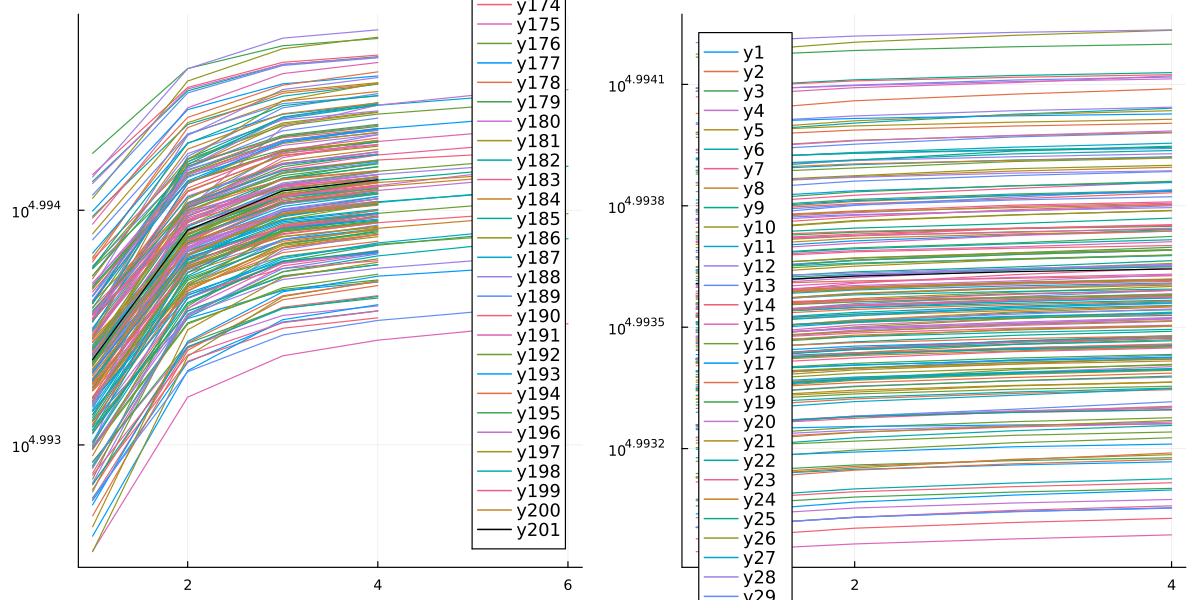

In [38]:
plot(
    map(result.history[1:1:end]) do h
        p = plot()
        for x in h.ẑ_history_sims
            plot!(first.(x), yscale=:log10)
        end
        plot!(first.(h.ẑ_history_dat), yscale=:log10, c=:black)
        p
    end...,
    size = (1000,500),
    xticks = 0:2:15,
    # ylim = (1e-7, 1e-3)
)

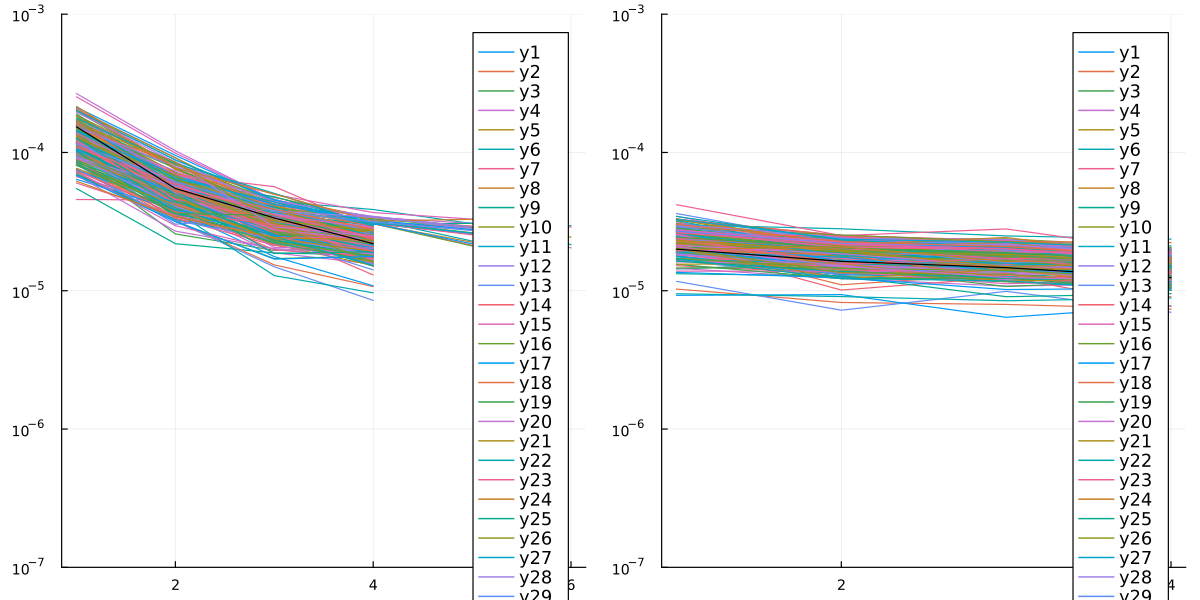

In [39]:
plot(
    map(result.history[1:1:end]) do h
        p = plot()
        for x in h.ẑ_history_sims
            plot!(last.(x), yscale=:log10)
        end
        plot!(last.(h.ẑ_history_dat), yscale=:log10, c=:black)
        p
    end...,
    size = (1000,500),
    xticks = 0:2:15,
    ylim = (1e-7, 1e-3)
)

┌ Warning: Skipped marker arg ..
└ @ Plots ~/.julia/packages/Plots/B5j7d/src/args.jl:1147
┌ Warning: Skipped marker arg ..
└ @ Plots ~/.julia/packages/Plots/B5j7d/src/args.jl:1147


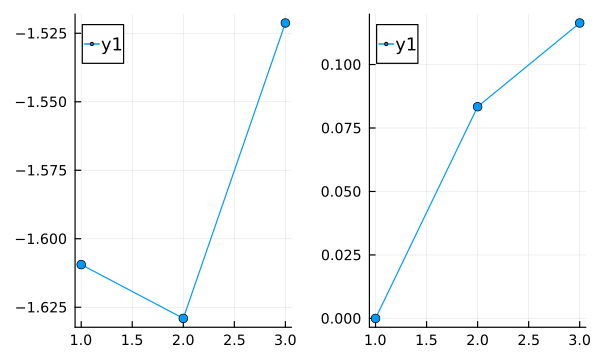

In [40]:
plot(
    plot(getindex.([getindex.(result.history, :θ); [result.θ]], :r), m="."),
    plot(getindex.([getindex.(result.history, :θ); [result.θ]], :Aϕ), m=".")
)

# Compare

In [49]:
ess_per_call_muse ./ minimum(ess_per_call_hmc)

31.755308836016635

In [50]:
ess_per_call_muse ./ minimum(ess_per_call_mchmc)

7.149650035604122

In [51]:
ess_per_call_mchmc

2-element Vector{Float64}:
 0.0009226663091188539
 0.003801399872553483

In [52]:
ess_per_call_hmc

2-element Vector{Float64}:
 0.0002077366415772459
 0.00028330503372299816

In [53]:
ess_per_call_muse

0.006596741209842338

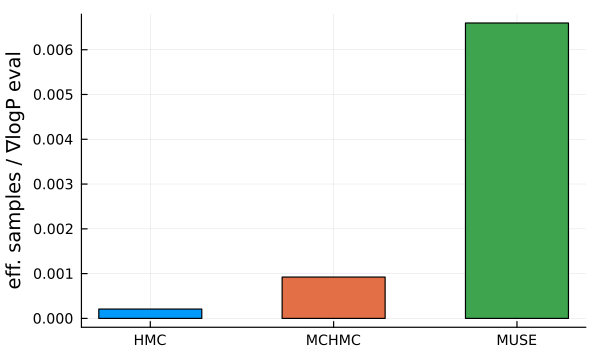

In [54]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(
    ["HMC" "MCHMC" "MUSE"],
    which_ess.([[ess_per_call_hmc] [ess_per_call_mchmc] [ess_per_call_muse]]),
    ylabel = "eff. samples / ∇logP eval", legend=false)

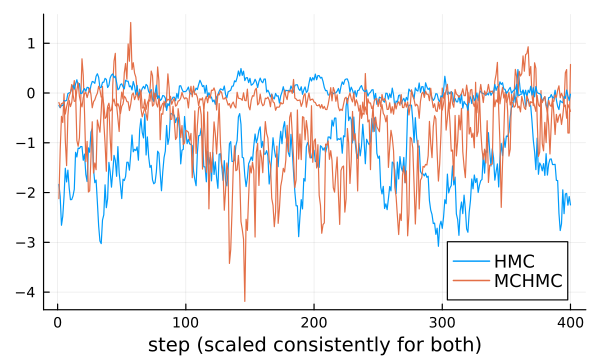

In [55]:
p = plot(label=L"r", xlabel="step (scaled consistently for both)")
for k in [:r, :Aϕ]
    plot!(log.(chain_hmc[k][1:length(chain_mchmc)÷25]), c=1, label=(k==:r ? "HMC" : nothing))
    plot!(log.(chain_mchmc[k][1:25:end]), c=2, label=(k==:r ? "MCHMC" : nothing))
end
p

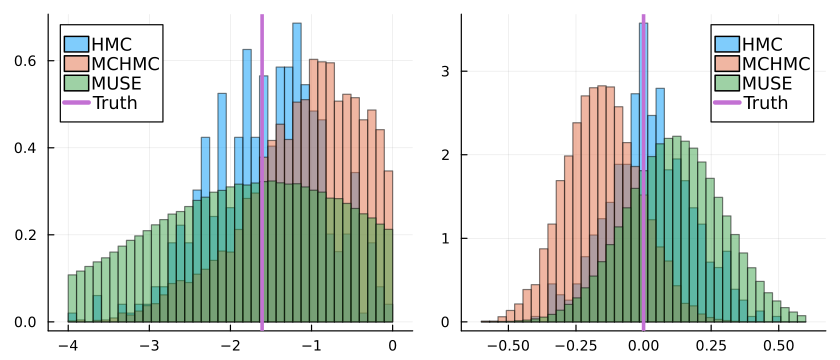

In [56]:
plot(
    begin
        histogram(log.(chain_hmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MCHMC")
        histogram!(chain_muse[:logr], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.r], c=4, lw=3, label="Truth")
    end, 
    begin
        histogram(log.(chain_hmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MCHMC")
        histogram!(chain_muse[:logAϕ], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.Aϕ], c=4, lw=3, label="Truth")
    end, 
    size = (700, 300)
)